# 1. Random walks

In [3]:
import random


def generate_random_walks(graph, walks_per_vertex, walk_length):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(walks_per_vertex):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            for _ in range(walk_length - 1):
                neighbors = list(graph.neighbors(walk[-1]))
                if neighbors:
                    walk.append(random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

## Example: Generate random walks of length 10 iterating over the vertex set 10 times

In [4]:
import networkx as nx

G = nx.karate_club_graph()

generate_random_walks(G, walks_per_vertex=10, walk_length=10)

[[30, 1, 3, 2, 1, 13, 1, 3, 7, 0],
 [2, 7, 0, 17, 0, 19, 0, 17, 0, 2],
 [19, 0, 31, 33, 19, 0, 10, 0, 2, 3],
 [24, 31, 32, 29, 33, 20, 32, 18, 33, 14],
 [8, 2, 13, 1, 7, 0, 21, 0, 13, 1],
 [17, 0, 1, 13, 2, 27, 24, 31, 25, 23],
 [25, 31, 32, 20, 32, 29, 32, 30, 1, 13],
 [21, 0, 19, 33, 22, 33, 29, 32, 15, 32],
 [6, 16, 5, 16, 5, 0, 13, 3, 0, 12],
 [29, 32, 29, 33, 13, 0, 4, 0, 5, 16],
 [13, 2, 28, 31, 28, 2, 7, 3, 12, 3],
 [15, 32, 2, 3, 2, 0, 6, 4, 6, 5],
 [10, 0, 11, 0, 13, 2, 8, 30, 1, 30],
 [20, 33, 20, 32, 33, 15, 33, 8, 30, 1],
 [28, 33, 29, 32, 15, 33, 31, 33, 18, 33],
 [4, 6, 5, 0, 13, 1, 3, 13, 0, 19],
 [11, 0, 19, 33, 20, 33, 19, 33, 28, 31],
 [7, 3, 12, 0, 2, 0, 2, 1, 19, 0],
 [1, 0, 3, 2, 7, 3, 12, 3, 2, 1],
 [12, 0, 12, 0, 2, 13, 0, 6, 0, 4],
 [31, 32, 33, 14, 33, 22, 33, 18, 33, 31],
 [16, 6, 4, 0, 2, 7, 2, 28, 31, 32],
 [14, 32, 30, 1, 30, 1, 3, 0, 1, 30],
 [33, 32, 2, 1, 0, 5, 16, 5, 16, 6],
 [23, 33, 32, 29, 23, 25, 24, 27, 33, 14],
 [26, 29, 26, 29, 23, 27, 24, 27, 23

# 2. Implement and train CBOW model

## 2.1. Implement CBOW model

In [5]:
import torch.nn as nn


class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.linear = nn.Linear(in_features=embedding_dim, out_features=vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, context):
        embedded = self.embeddings(context)
        context_mean = embedded.mean(dim=1)
        out = self.linear(context_mean)
        return self.softmax(out)

## 2.2. Generate training samples (tuples with context and target for each node)

In [6]:
def generate_training_samples(walks, window_size):
    samples = []
    half_window = (window_size - 1) // 2
    for walk in walks:
        for i in range(half_window, len(walk) - half_window):
            context = (
                    walk[i - half_window:i] + walk[i + 1:i + 1 + half_window]
            )
            target = walk[i]
            samples.append((context, target))
    return samples

## 2.3. Train the CBOW model

In [30]:
import torch
import torch.optim as optim


def train_cbow(graph, walks_per_vertex, walk_length, window_size, embedding_dim, epochs):
    print("Generating random walks...")
    walks = generate_random_walks(graph, walks_per_vertex, walk_length)

    print("Creating training samples...")
    samples = generate_training_samples(walks, window_size)

    nodes = list(graph.nodes())
    vocab_size = len(nodes)
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}

    indexed_samples = [
        ([node_to_idx[node] for node in context], node_to_idx[target])
        for context, target in samples
    ]

    model = CBOW(vocab_size, embedding_dim)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters())

    print("Training CBOW model...")
    for epoch in range(epochs):
        for context, target in indexed_samples:
            context_tensor = torch.tensor(context, dtype=torch.long).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.long)

            # Forward pass
            output = model(context_tensor)
            loss = loss_fn(output, target_tensor)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}")

    embeddings = model.embeddings.weight.detach().numpy()
    return {idx_to_node[idx]: embeddings[idx] for idx in range(vocab_size)}

# 3. Use Deepwalk on the Zachary Karate Club graph

## 3.1. Configuration parameters for Deepwalk

In [28]:
walks_per_vertex = 10
walk_length = 10
window_size = 3
embedding_dim = 64
epochs = 10

## 3.2. Run the model

In [31]:
import networkx as nx

G = nx.karate_club_graph()

embeddings = train_cbow(
    graph=G,
    walks_per_vertex=walks_per_vertex,
    walk_length=walk_length,
    window_size=window_size,
    embedding_dim=embedding_dim,
    epochs=epochs
)

for node, embedding in list(embeddings.items())[:5]:
    print(f"Node {node}: {embedding[:5]}...")  # Show the first 5 dimensions

Generating random walks...
Creating training samples...
Training CBOW model...
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Node 0: [ 1.1900349  -1.3017946   0.25042644  0.17548849 -0.4483822 ]...
Node 1: [ 1.3528241 -0.9115858  0.9570135  0.6730113  2.3103964]...
Node 2: [0.3446775  0.6073769  1.6936768  0.35869905 0.76157105]...
Node 3: [-0.54996264 -2.4286885   0.10675599  1.5976623   0.5125607 ]...
Node 4: [ 1.580652   -0.44032267  0.44482788  0.35329562 -0.22273794]...


## 3.3. Convert the embeddings to an np.array

In [15]:
import numpy as np

embedding_list = list(embeddings.values())
embeddings_np = np.array(embedding_list)
embeddings_np

array([[-0.75775266, -0.79518646,  1.9076562 , ...,  0.35415727,
         0.04622803, -0.49789467],
       [-0.605796  , -0.8687219 , -0.5908417 , ...,  0.38972533,
         0.10453782,  1.0535249 ],
       [ 1.0565692 ,  0.14471413, -0.01180033, ..., -1.7459865 ,
         1.970285  ,  0.7515759 ],
       ...,
       [ 0.93737787, -0.12159958, -0.956122  , ...,  0.45383617,
        -1.458851  , -0.73618436],
       [ 1.3514829 , -0.8823955 ,  0.7212402 , ...,  0.16248097,
        -0.7732051 ,  0.76104265],
       [ 2.2767665 , -0.9698813 , -0.40061736, ..., -0.1927961 ,
        -0.16309889,  1.6766855 ]], shape=(34, 64), dtype=float32)

## 3.4. Use tSNE to reduce the embedding space to 2 dimensions

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE()
X_embedded = tsne.fit_transform(embeddings_np)

X_embedded

array([[0.94592804, 2.657079  ],
       [0.5981144 , 2.2091677 ],
       [1.3082443 , 1.8723881 ],
       [1.5757647 , 2.6372142 ],
       [0.95462203, 1.6942728 ],
       [1.0687661 , 3.1267874 ],
       [1.0133469 , 2.4609118 ],
       [1.3522667 , 2.8012488 ],
       [1.7683542 , 2.581552  ],
       [1.6110365 , 2.8647451 ],
       [1.0570017 , 1.9343305 ],
       [1.6910193 , 1.9753495 ],
       [1.6413769 , 2.3421412 ],
       [1.4626231 , 1.7901264 ],
       [0.89064753, 2.0385425 ],
       [1.5970577 , 2.4288406 ],
       [1.4609312 , 2.631002  ],
       [1.1938872 , 1.7267091 ],
       [0.77256715, 2.6271186 ],
       [0.98125637, 2.1280687 ],
       [0.7269957 , 2.2821655 ],
       [1.0954074 , 2.6700974 ],
       [0.9195077 , 2.7738602 ],
       [1.1433334 , 2.815727  ],
       [1.5941461 , 2.3088186 ],
       [1.8109621 , 2.2784176 ],
       [1.0038002 , 2.0878513 ],
       [1.3267664 , 2.0909698 ],
       [1.347837  , 2.6456745 ],
       [1.7196196 , 2.4481244 ],
       [1.

## 3.5. Plot the result of tSNE

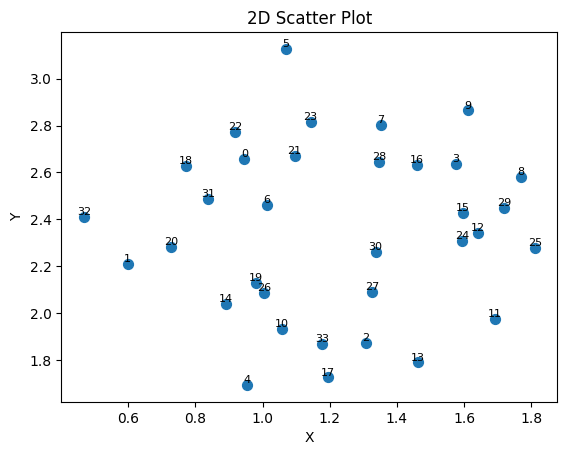

In [24]:
import matplotlib.pyplot as plt

x_coords = [point[0] for point in X_embedded]
y_coords = [point[1] for point in X_embedded]

plt.scatter(x_coords, y_coords, s=50)

for i, point in enumerate(X_embedded):
    plt.text(point[0], point[1], str(i), ha='center', va='bottom', fontsize=8)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter Plot')

plt.show()